### Загрузка необходимых библиотек ###

In [2]:
#pip install bleach

In [3]:
#pip install keras

In [4]:
#pip install tensorflow

In [5]:
import pandas as pd
import numpy as np
import sklearn
import keras
import nltk
import re
import codecs
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from nltk.tokenize import RegexpTokenizer
from tensorflow.keras.preprocessing.text import Tokenizer
from  keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import PCA, TruncatedSVD
import matplotlib
import seaborn as sns
import matplotlib.patches as mpatches
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, r2_score, classification_report
import itertools
from sklearn.metrics import confusion_matrix
!python -m gensim.downloader --download word2vec-google-news-300
import gensim
!pip install lime
from lime import lime_text
from sklearn.pipeline import make_pipeline
from lime.lime_text import LimeTextExplainer
import random
from collections import defaultdict
from tensorflow.keras.preprocessing.text  import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate
from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import LSTM, Bidirectional
from keras.models import Model

^C
^C


### Просмотр и предобработка данных ###

Описание датасета:

https://archive.ics.uci.edu/dataset/228/sms+spam+collection

Набор содержит 5572 сообщения, которые делятся на две группы: спам-сообщения и обычные сообщения.

target - целевая переменная.

Задача: Классификация методами NLP.

In [6]:
url = 'spam.csv'
data = pd.read_csv(url,encoding="latin1")
data.drop(columns = ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)
data.rename(columns = {'v1': 'target', 'v2': 'text'}, inplace = True)
display(data)

target                                               text
0       ham  Go until jurong point, crazy.. Available only ...
1       ham                      Ok lar... Joking wif u oni...
2      spam  Free entry in 2 a wkly comp to win FA Cup fina...
3       ham  U dun say so early hor... U c already then say...
4       ham  Nah I don't think he goes to usf, he lives aro...
...     ...                                                ...
5567   spam  This is the 2nd time we have tried 2 contact u...
5568    ham              Will Ì_ b going to esplanade fr home?
5569    ham  Pity, * was in mood for that. So...any other s...
5570    ham  The guy did some bitching but I acted like i'd...
5571    ham                         Rofl. Its true to its name

[5572 rows x 2 columns]

In [7]:
data.tail()

target                                               text
5567   spam  This is the 2nd time we have tried 2 contact u...
5568    ham              Will Ì_ b going to esplanade fr home?
5569    ham  Pity, * was in mood for that. So...any other s...
5570    ham  The guy did some bitching but I acted like i'd...
5571    ham                         Rofl. Its true to its name

In [8]:
data.describe()

target                    text
count    5572                    5572
unique      2                    5169
top       ham  Sorry, I'll call later
freq     4825                      30

Проверка повторяющихся сообщений(может помешать обучению модели):

In [10]:
data.duplicated().sum()

403

In [11]:
data = data.drop_duplicates(keep = 'first')

In [12]:
data.shape

(5169, 2)

Стандартизация текста: 

Приведение всех слов к нижнему регистру для упрощения обычения. Для улучшения классификации, различные символы не были удалены.

In [13]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.lower()
    return df

questions = standardize_text(data, "text")

questions.to_csv("clean_df.csv")
display(questions)

target                                               text
0       ham  go until jurong point, crazy.. available only ...
1       ham                      ok lar... joking wif u oni...
2      spam  free entry in 2 a wkly comp to win fa cup fina...
3       ham  u dun say so early hor... u c already then say...
4       ham  nah i don't think he goes to usf, he lives aro...
...     ...                                                ...
5567   spam  this is the 2nd time we have tried 2 contact u...
5568    ham              will ì_ b going to esplanade fr home?
5569    ham  pity, * was in mood for that. so...any other s...
5570    ham  the guy did some bitching but i acted like i'd...
5571    ham                         rofl. its true to its name

[5169 rows x 2 columns]

Сохраним наш отчищенный и подготовленный датасет:

In [14]:
clean_questions = pd.read_csv("clean_df.csv")
clean_questions.tail()

Unnamed: 0 target                                               text
5164        5567   spam  this is the 2nd time we have tried 2 contact u...
5165        5568    ham              will ì_ b going to esplanade fr home?
5166        5569    ham  pity, * was in mood for that. so...any other s...
5167        5570    ham  the guy did some bitching but i acted like i'd...
5168        5571    ham                         rofl. its true to its name

In [15]:
clean_questions.groupby("target").count()

Unnamed: 0  text
target                  
ham           4516  4516
spam           653   653

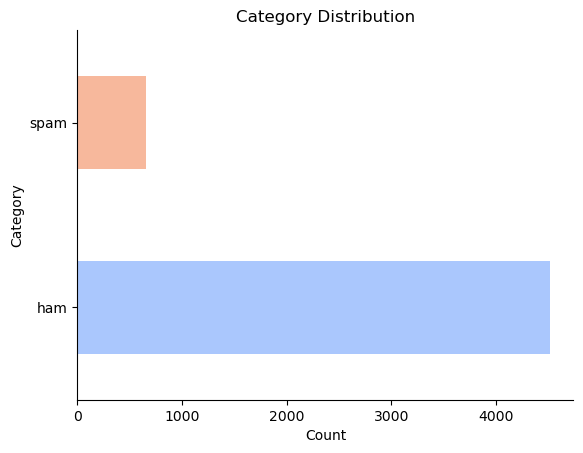

In [16]:
# Group data by 'target' and plot
clean_questions.groupby('target').size().plot(
    kind='barh',
    color=sns.color_palette('coolwarm', n_colors=2)  # Apply 'coolwarm' palette with 2 colors
)

# Remove top and right spines
plt.gca().spines[['top', 'right']].set_visible(False)

# Add labels and title
plt.xlabel('Count')
plt.ylabel('Category')
plt.title('Category Distribution')

# Display the plot
plt.show()

Как видно из диаграммы, наши классы не сбалансированы.

Балансировать мы их не будем, посмотрим, как обучиться наша модель на несбалансированных данных.

Построим карту слов:

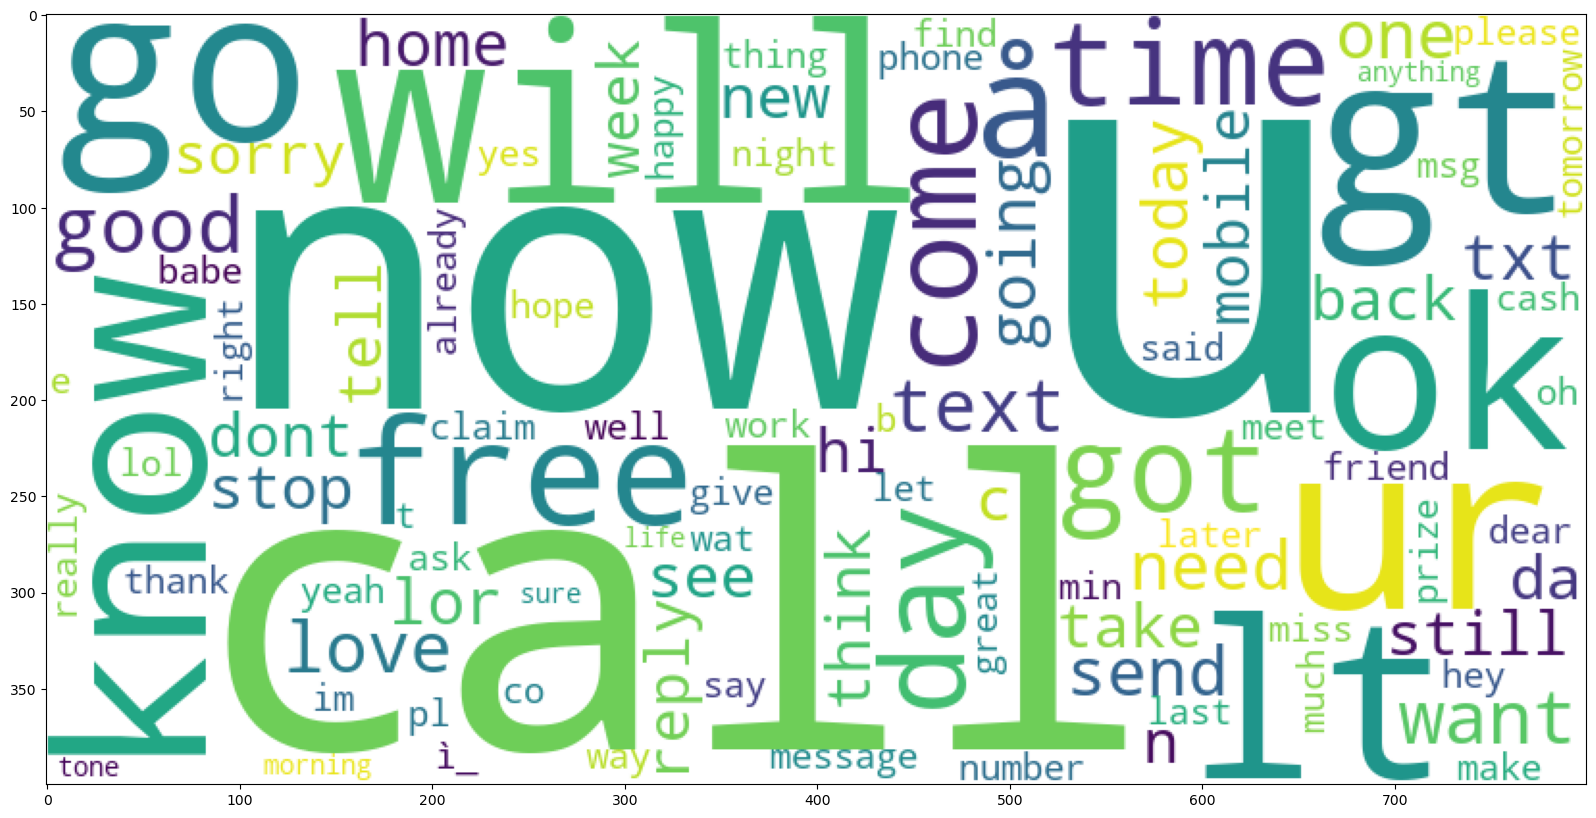

In [19]:
a = " ".join(clean_questions["text"])
en_cloud = WordCloud(max_words=100, background_color='white',
                     width=800, height=400,
                     collocations=False).generate(a)
fig = plt.figure(figsize=(20, 10))
plt.imshow(en_cloud);

Карта слов — это удобный способ увидеть, какие слова наиболее распространены в тексте. Он часто применяется в анализе текста, чтобы быстро получить представление о тематике и ключевых словах. 

Как видно из нашей карты слов, чаще всего употребляются совершенно обычные слова, свойственные не только спам-сообщениям.

### Подготовка данных к обучению ###

Теперь, когда наши входные данные стали более разумными, преобразуем их так, чтобы наша модель могла их понять. Из этого следует:
- Токенизация предложений в список отдельных слов
- Создание тестового сплита трейна
- Еще немного проверяем наши данные, чтобы подтвердить результаты.

In [20]:
tokenizer = RegexpTokenizer(r'\w+')
clean_questions["tokens"] = clean_questions["text"].apply(tokenizer.tokenize)
clean_questions.head()

Unnamed: 0 target                                               text  \
0           0    ham  go until jurong point, crazy.. available only ...   
1           1    ham                      ok lar... joking wif u oni...   
2           2   spam  free entry in 2 a wkly comp to win fa cup fina...   
3           3    ham  u dun say so early hor... u c already then say...   
4           4    ham  nah i don't think he goes to usf, he lives aro...   

                                              tokens  
0  [go, until, jurong, point, crazy, available, o...  
1                     [ok, lar, joking, wif, u, oni]  
2  [free, entry, in, 2, a, wkly, comp, to, win, f...  
3  [u, dun, say, so, early, hor, u, c, already, t...  
4  [nah, i, don, t, think, he, goes, to, usf, he,...

Проанализируем длины сообщений:

In [21]:
all_words = [word for tokens in clean_questions["tokens"] for word in tokens]
sentence_lengths = [len(tokens) for tokens in clean_questions["tokens"]]
VOCAB = sorted(list(set(all_words)))
print("%s words total, with a vocabulary size of %s" % (len(all_words), len(VOCAB)))
print("Max sentence length is %s" % max(sentence_lengths))

82652 words total, with a vocabulary size of 8713
Max sentence length is 190


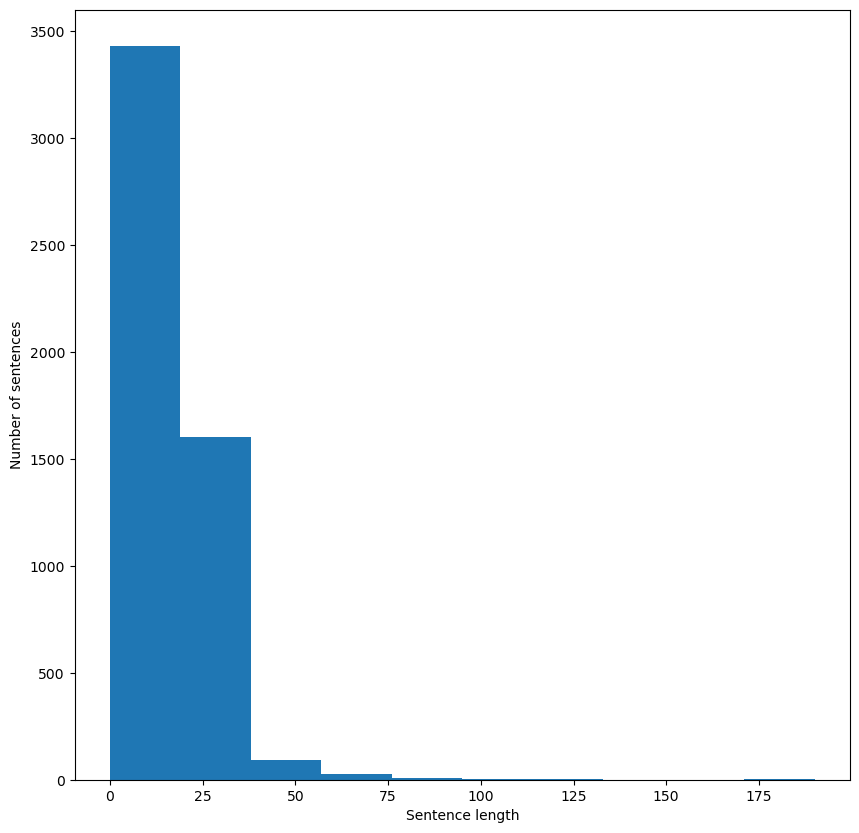

In [22]:
fig = plt.figure(figsize=(10, 10))
plt.xlabel('Sentence length')
plt.ylabel('Number of sentences')
plt.hist(sentence_lengths)
plt.show()

В большинстве своём сообщения короткие, состоят из 25-35 слов. Максимальная длина сообщения - 190 слов

### Построение модели ###

Самый простой подход, с которого мы можем начать, — это использовать модель мешка слов и применить к ней логистическую регрессию. Мешок слов - мы можем построить словарь всех уникальных слов в нашем датасете, и ассоциировать уникальный индекс каждому слову в словаре. Каждое предложение тогда можно будет отобразить списком, длина которого равна числу уникальных слов в нашем словаре, а в каждом индексе в этом списке будет хранится, сколько раз данное слово встречается в предложении. То есть мешок слов просто связывает индекс с каждым словом в нашем словаре и встраивает каждое предложение в виде списка нулей, с 1 в каждом индексе, соответствующем слову, присутствующему в предложении.

In [23]:
def cv(data):
    count_vectorizer = CountVectorizer()
    emb = count_vectorizer.fit_transform(data)
    return emb, count_vectorizer

from sklearn.preprocessing import LabelEncoder
#Замена категориальных признаков на качественные
label_enc = LabelEncoder()
clean_questions["target"] = label_enc.fit_transform(clean_questions["target"])
list_corpus = clean_questions["text"].tolist()
list_labels = clean_questions["target"].tolist()

X_train, X_test, y_train, y_test = train_test_split(list_corpus, list_labels, test_size=0.2,
                                                                                random_state=40)

X_train_counts, count_vectorizer = cv(X_train)
X_test_counts = count_vectorizer.transform(X_test)

Визуализируем векторные представления:

В словаре "Спам-сообщения" содержится около 9 000 слов. Это означает, что каждое предложение будет отражено вектором длиной 9 000. Этот вектор будет содержать преимущественно нули, поскольку каждое предложение содержит лишь малое подмножество из нашего словаря.

Для того, чтобы выяснить, захватывают ли наши векторные представления (embeddings), релевантную нашей задаче информацию (например, сообщение является спамом или нет), стоит попробовать визуализировать их и посмотреть, насколько хорошо разделены эти классы. Поскольку словари обычно являются очень большими и визуализация данных на 9 000 измерений невозможна, подходы вроде метода главных компонент (PCA) помогают спроецировать данные на два измерения.

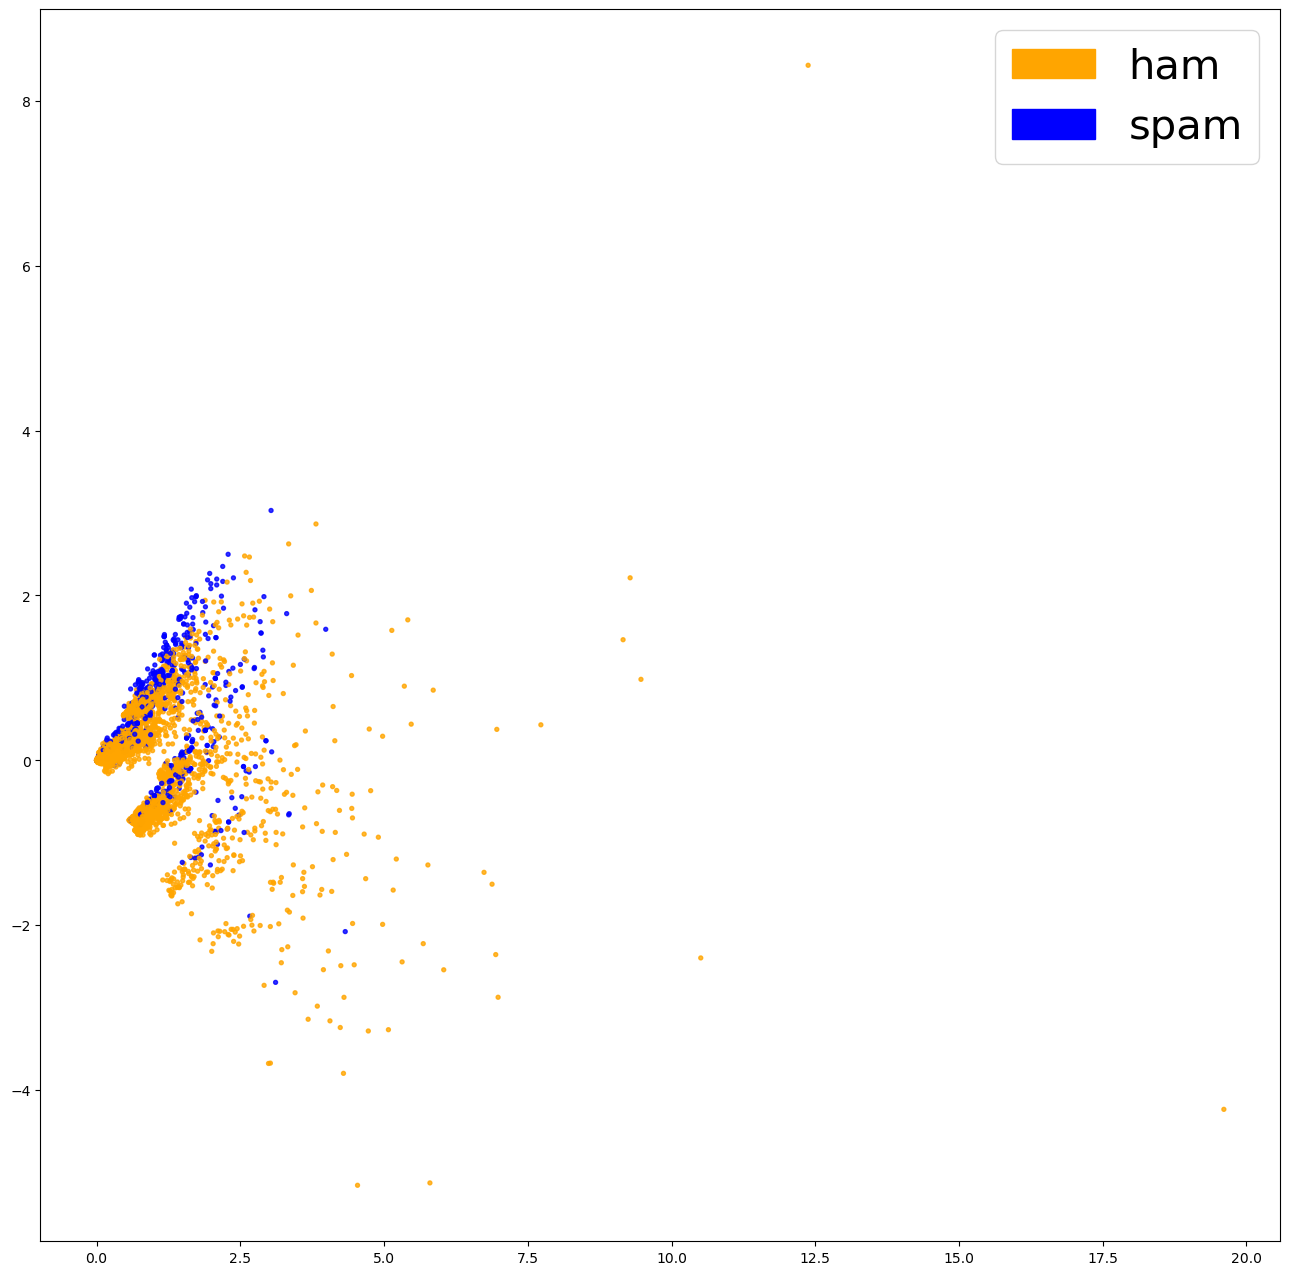

In [202]:

def plot_LSA(test_data, test_labels, savepath="PCA_demo.csv", plot=True):
        lsa = TruncatedSVD(n_components=2)
        lsa.fit(test_data)
        lsa_scores = lsa.transform(test_data)
        color_mapper = {label:idx for idx,label in enumerate(set(test_labels))}
        color_column = [color_mapper[label] for label in test_labels]
        colors = ['orange','blue']
        if plot:
            plt.scatter(lsa_scores[:,0], lsa_scores[:,1], s=8, alpha=.8, c=test_labels, cmap=matplotlib.colors.ListedColormap(colors))
            red_patch = mpatches.Patch(color='orange', label='ham')
            green_patch = mpatches.Patch(color='blue', label='spam')
            plt.legend(handles=[red_patch, green_patch], prop={'size': 30})


fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_counts, y_train)
plt.show()

Разделение не очень хорошее, попробуем применить логистическую регрессию.

In [142]:
from sklearn.linear_model import LogisticRegression

clf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg', n_jobs=-1, random_state=40)
clf.fit(X_train_counts, y_train)

y_predicted_counts = clf.predict(X_test_counts)
from sklearn.metrics import classification_report, confusion_matrix
print(pd.Series(y_train).value_counts(normalize=True)) # Доля каждого класса в тренировочных данных
print(pd.Series(y_test).value_counts(normalize=True))  # Доля каждого класса в тестовых данных

0    0.870617
1    0.129383
Name: proportion, dtype: float64
0    0.88588
1    0.11412
Name: proportion, dtype: float64


Вычислим метрики:

In [144]:
def get_metrics(y_test, y_predicted):
    # true positives / (true positives+false positives)
    precision = precision_score(y_test, y_predicted, pos_label=None,
                                    average='weighted')
    # true positives / (true positives + false negatives)
    recall = recall_score(y_test, y_predicted, pos_label=None,
                              average='weighted')

    # harmonic mean of precision and recall
    f1 = f1_score(y_test, y_predicted, pos_label=None, average='weighted')

    r2 = r2_score(y_test, y_predicted)
    # true positives + true negatives/ total
    accuracy = accuracy_score(y_test, y_predicted)
    return accuracy, precision, recall, f1, r2

accuracy, precision, recall, f1, r2 = get_metrics(y_test, y_predicted_counts)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy, precision, recall, f1,r2))

accuracy = 0.985, precision = 0.984, recall = 0.985, f1 = 0.984, r2 = 0.847


Модель демонстрирует исключительно высокую точность, точность (precision) и полноту (recall). Она очень надежна как в правильном определении положительных случаев, так и в избегании ложных срабатываний. Почти идеальная F1-мера подтверждает эту сбалансированную производительность. 

Посмотрим на матрицу ошибок

In [146]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.winter):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize=30)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, fontsize=20)
    plt.yticks(tick_marks, classes, fontsize=20)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 3.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] < thresh else "black", fontsize=40)

    plt.tight_layout()
    plt.ylabel('True label', fontsize=30)
    plt.xlabel('Predicted label', fontsize=30)

    return plt

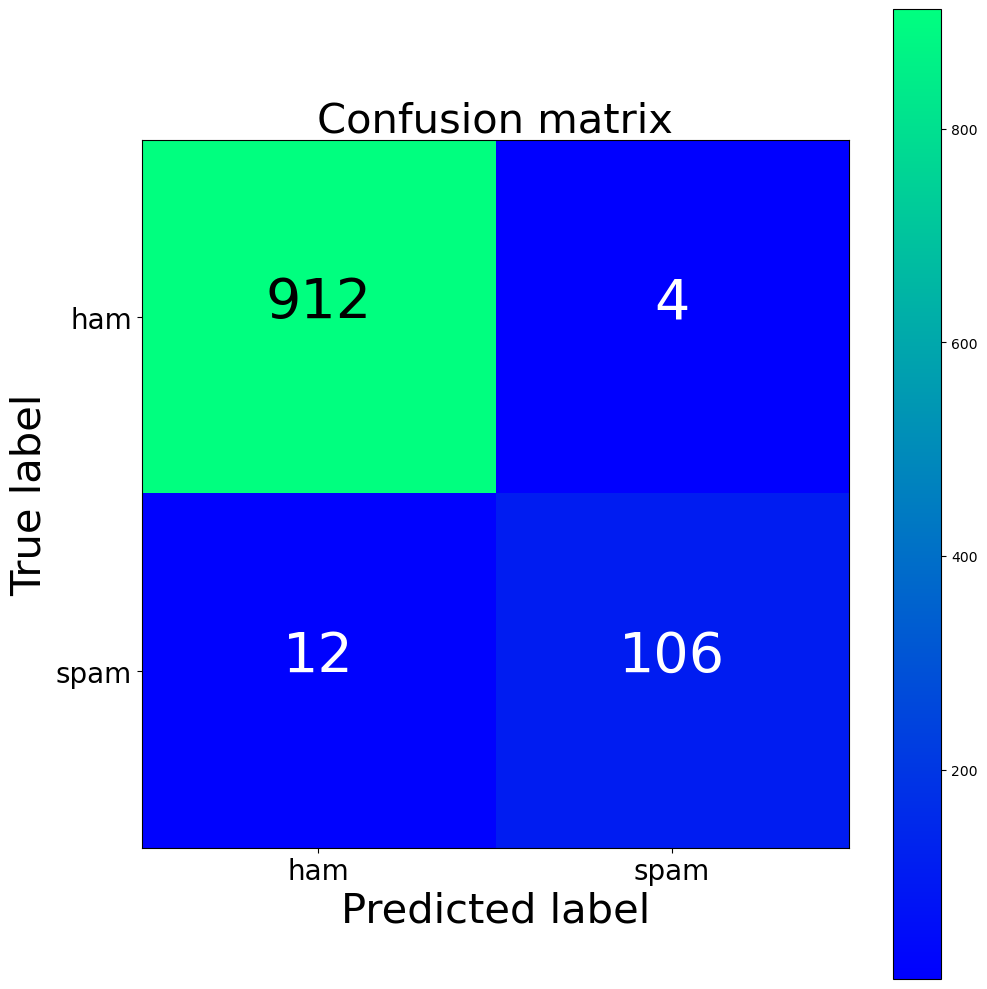

[[912   4]
 [ 12 106]]


In [148]:
cm = confusion_matrix(y_test, y_predicted_counts)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['ham', 'spam'], normalize=False, title='Confusion matrix')
plt.show()
print(cm)

Наш классификатор создает больше ложно-отрицательных, чем ложно-положительных результатов, но в основном очень хорошо справляется.

#### Инспектируем дальше

Чтобы произвести валидацию нашей модели и интерпретировать ее предсказания, важно посмотреть на то, какие слова она использует для принятия решений. Если наши данные смещены, наш классификатор произведет точные предсказания на выборочных данных, но модель не сможет достаточно хорошо обобщить их в реальном мире. На диаграмме ниже показаны наиболее значимые слова для классов спам-сообщений и обычных сообщений. Составление диаграмм, отражающих значимость слов, не составляет трудностей в случае использования «мешка слов» и логистической регрессии, поскольку мы просто извлекаем и ранжируем коэффициенты, которые модель использует для своих предсказаний.

Посмотрим, на каких признаках наш классификатор делает предсказание.

In [182]:
def get_most_important_features(vectorizer, model, n=5):
  index_to_word = {v:k for k,v in vectorizer.vocabulary_.items()}

  # loop for each class
  classes ={}
  for class_index in range(model.coef_.shape[0]):
    word_importances = [(el, index_to_word[i]) for i,el in enumerate(model.coef_[class_index])]
    sorted_coeff = sorted(word_importances, key = lambda x : x[0], reverse=True)
    tops = sorted(sorted_coeff[:n], key = lambda x : x[0])
    bottom = sorted_coeff[-n:]
    classes[class_index] = {
      'tops':tops,
      'bottom':bottom,
    }
  return classes

importance = get_most_important_features(count_vectorizer, clf, 10)

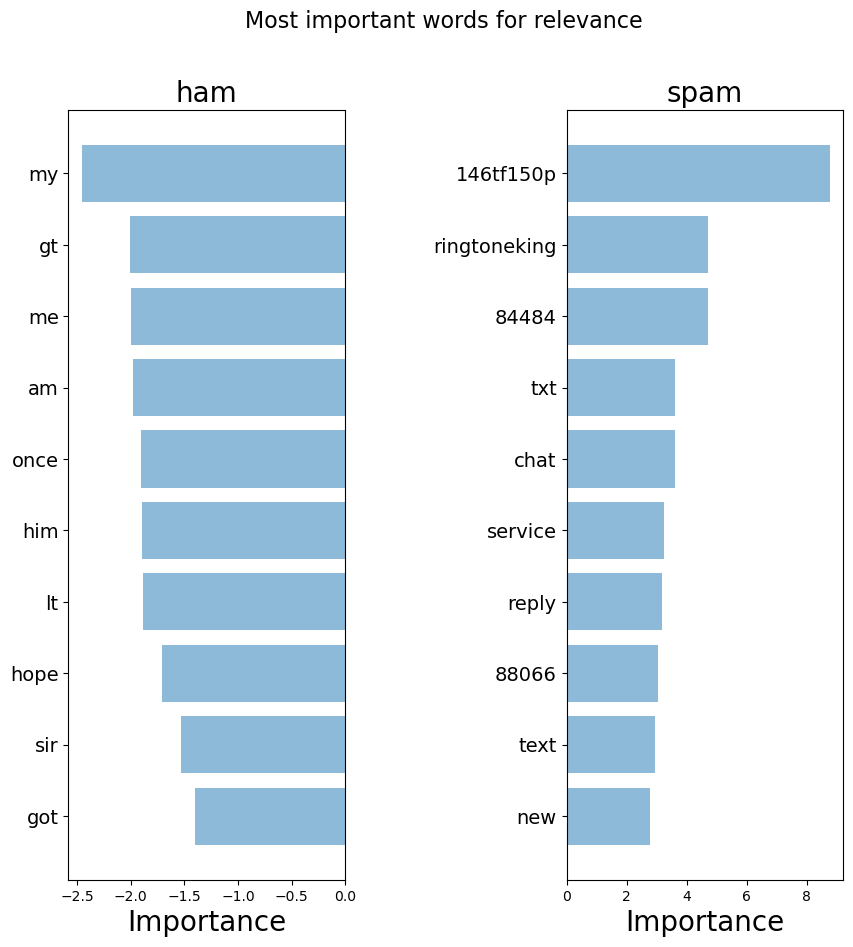

In [190]:
def plot_important_words(top_scores, top_words, bottom_scores, bottom_words, name):
    y_pos = np.arange(len(top_words))
    top_pairs = [(a,b) for a,b in zip(top_words, top_scores)]
    top_pairs = sorted(top_pairs, key=lambda x: x[1])

    bottom_pairs = [(a,b) for a,b in zip(bottom_words, bottom_scores)]
    bottom_pairs = sorted(bottom_pairs, key=lambda x: x[1], reverse=True)

    top_words = [a[0] for a in top_pairs]
    top_scores = [a[1] for a in top_pairs]

    bottom_words = [a[0] for a in bottom_pairs]
    bottom_scores = [a[1] for a in bottom_pairs]

    fig = plt.figure(figsize=(10, 10))

    plt.subplot(121)
    plt.barh(y_pos,bottom_scores, align='center', alpha=0.5)
    plt.title('ham', fontsize=20)
    plt.yticks(y_pos, bottom_words, fontsize=14)
    plt.suptitle('Key words', fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplot(122)
    plt.barh(y_pos,top_scores, align='center', alpha=0.5)
    plt.title('spam', fontsize=20)
    plt.yticks(y_pos, top_words, fontsize=14)
    plt.suptitle(name, fontsize=16)
    plt.xlabel('Importance', fontsize=20)

    plt.subplots_adjust(wspace=0.8)
    plt.show()

top_scores = [a[0] for a in importance[0]['tops']]
top_words = [a[1] for a in importance[0]['tops']]
bottom_scores = [a[0] for a in importance[0]['bottom']]
bottom_words = [a[1] for a in importance[0]['bottom']]
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Итак, сейчас наш «мешок слов» имеет дело с огромным словарем из различных слов и все эти слова для него равнозначны. Однако, некоторые из этих слов встречаются очень часто, и лишь добавляют шума нашим предсказаниям. Поэтому далее мы постараемся найти способ представить предложения таким образом, чтобы они могли учитывать частоту слов, и посмотрим, сможем ли мы получить больше полезной информации из наших данных.

#### Учитываем структуру словаря

Чтобы помочь нашей модели сфокусироваться на значимых словах, мы можем использовать скоринг TF-IDF (Term Frequency, Inverse Document Frequency) поверх нашей модели «мешка слов». TF-IDF взвешивает на основании того, насколько они редки в нашем датасете, понижая в приоритете слова, которые встречаются слишком часто и просто добавляют шум. Ниже приводится проекция метода главных компонент, позволяющая оценить наше новое представление.

In [116]:
def tfidf(data):
    tfidf_vectorizer = TfidfVectorizer()

    train = tfidf_vectorizer.fit_transform(data)

    return train, tfidf_vectorizer

X_train_tfidf, tfidf_vectorizer = tfidf(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

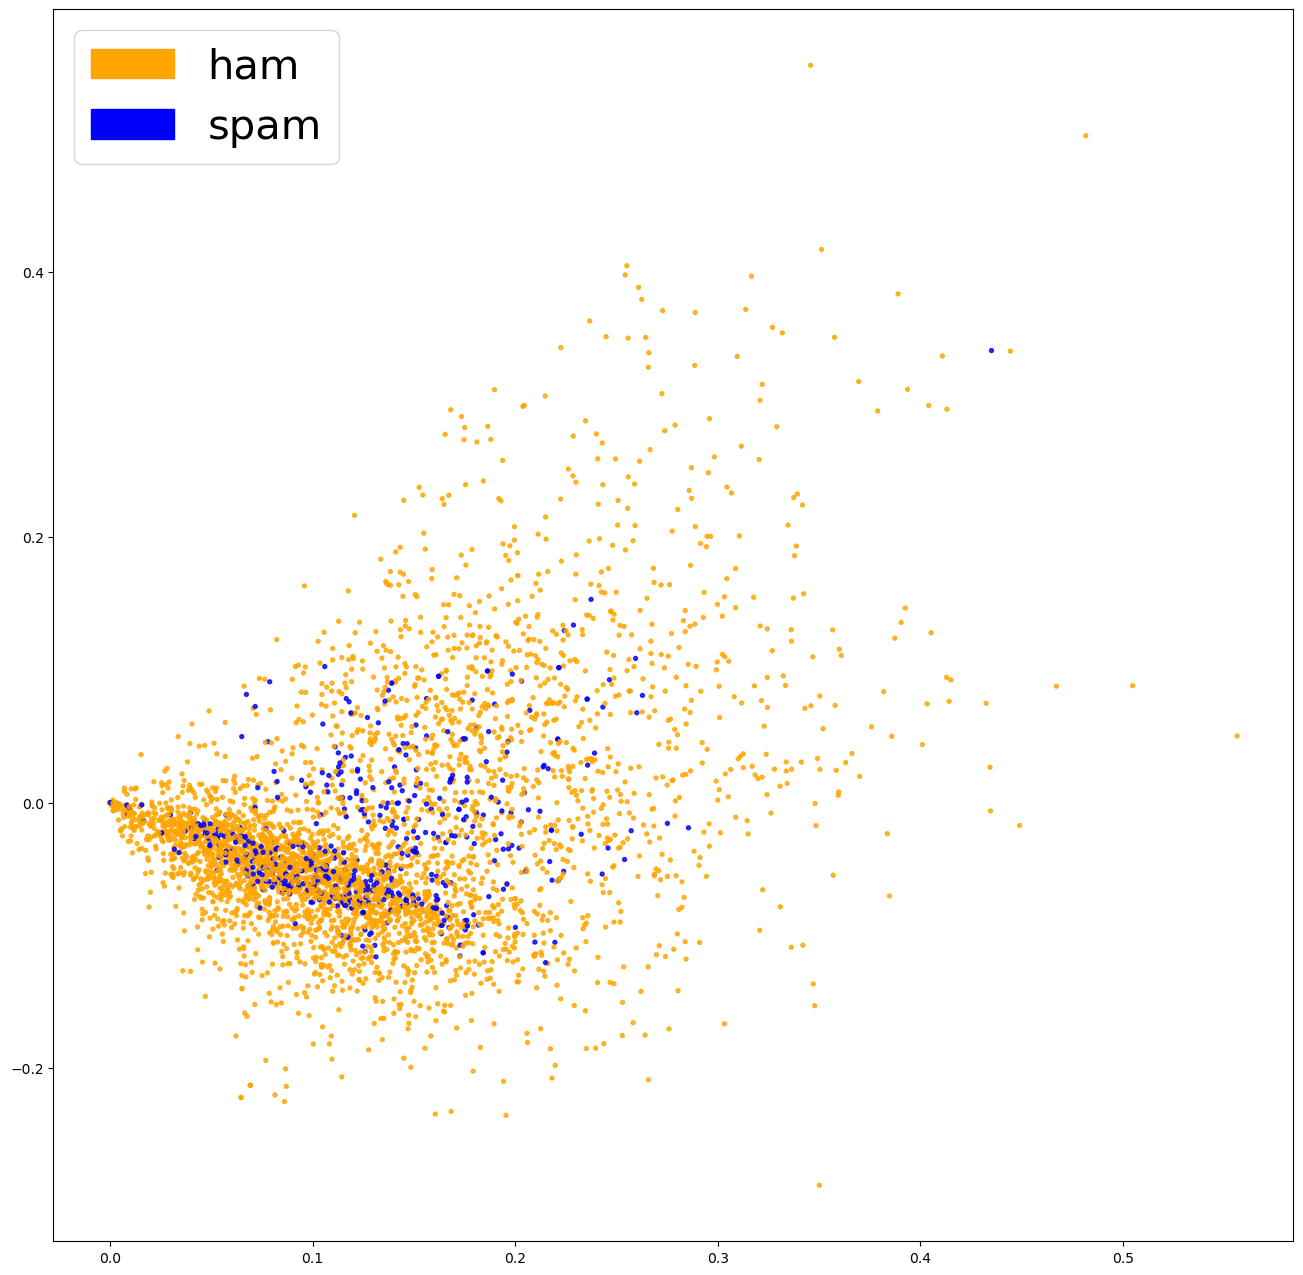

In [204]:
fig = plt.figure(figsize=(16, 16))
plot_LSA(X_train_tfidf, y_train)
plt.show()

Разделение наших классов стало более чётким.

In [119]:
clf_tfidf = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', n_jobs=-1, random_state=40)
clf_tfidf.fit(X_train_tfidf, y_train)

y_predicted_tfidf = clf_tfidf.predict(X_test_tfidf)

In [120]:
accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf, r2_tfidf = get_metrics(y_test, y_predicted_tfidf)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f"  % (accuracy_tfidf, precision_tfidf, recall_tfidf, f1_tfidf, r2_tfidf))


accuracy = 0.986, precision = 0.987, recall = 0.986, f1 = 0.987, r2 = 0.866


Точность модели стала еще лучше!

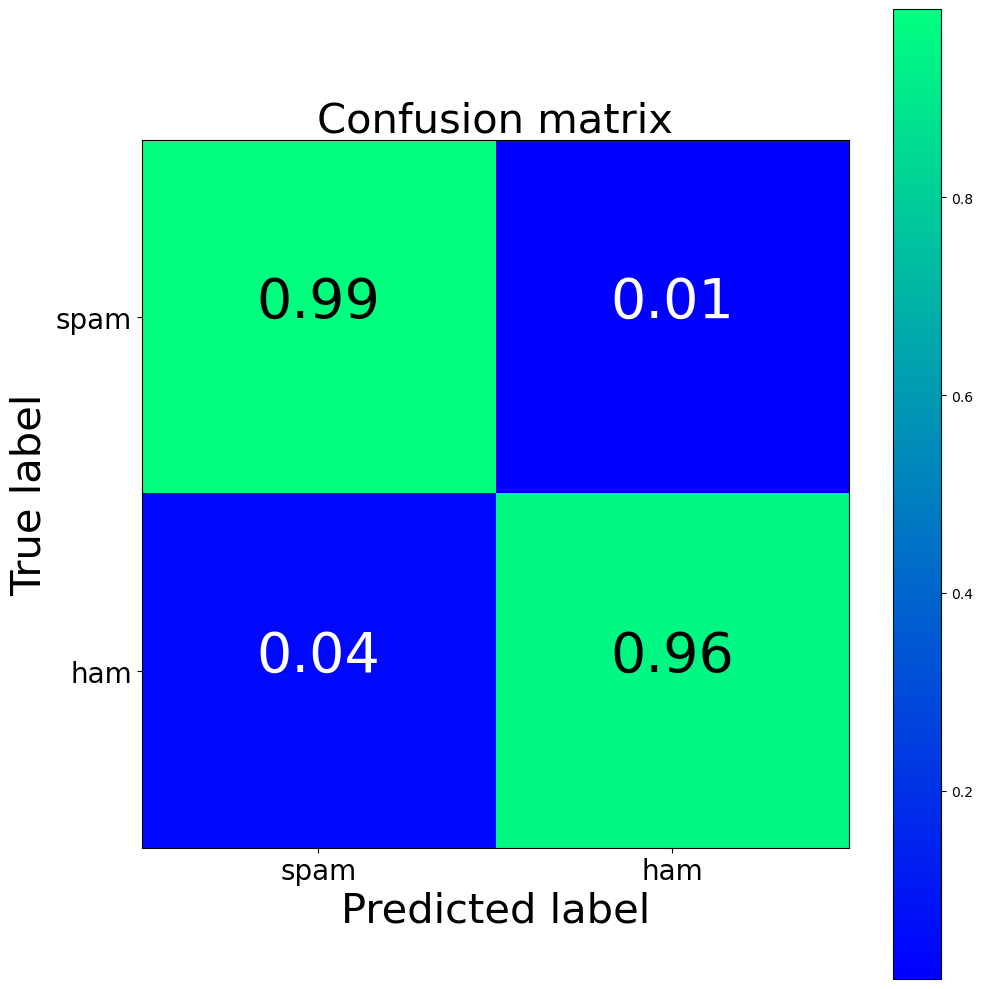

TFIDF confusion matrix
[[907   9]
 [  5 113]]
BoW confusion matrix
[[912   4]
 [ 12 106]]


In [121]:
cm2 = confusion_matrix(y_test, y_predicted_tfidf)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm2, classes=['spam','ham'], normalize=True, title='Confusion matrix')
plt.show()
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

#### Важность признаков для предсказания

In [132]:
importance_tfidf = get_most_important_features(tfidf_vectorizer, clf_tfidf, 10)

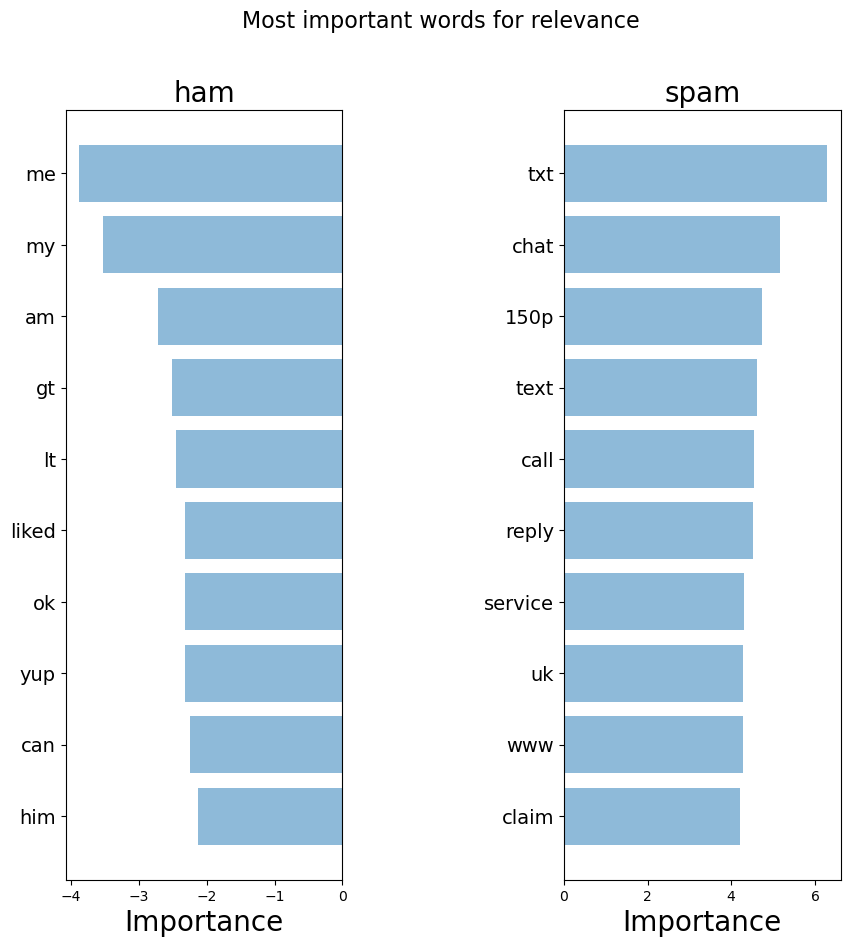

In [200]:
top_scores = [a[0] for a in importance_tfidf[0]['tops']]
top_words = [a[1] for a in importance_tfidf[0]['tops']]
bottom_scores = [a[0] for a in importance_tfidf[0]['bottom']]
bottom_words = [a[1] for a in importance_tfidf[0]['bottom']]
  
plot_important_words(top_scores, top_words, bottom_scores, bottom_words, "Most important words for relevance")

Выбранные моделью слова действительно выглядят гораздо более релевантными. Несмотря на то, что метрики на нашем тестовом множестве увеличились совсем незначительно, у нас теперь гораздо больше уверенности в использовании модели в реальной системе, которая будет взаимодействовать с клиентами.

### Применение семантики ###

Word2Vec

Наша последняя модель смогла «выхватить» слова, несущие наибольшее значение.днако в реальной жизни онанможет а столуньется со словами, которые не встречались в обучающей выборке — и не сможет точно классифицировать этсообщенияты, даже если она видела весьма похожие слова во время обучения.

Чтобы решить данную проблему, нам потребуется захватить семантическое (смысловое) значение слов — это означает, что для нас важно понимать, что слова «хороший» и «позитивный» ближе друг к другу, чем слова «абрикос» и «континент». Мы воспользуемся инструментом Word2Vec, который поможет нам сопоставить значения слов.

Использование результатов предварительного обучения

Word2Vec — это техника для поиска непрерывных отображений для слов. Word2Vec обучается на прочтении огромного количества текста с последующим запоминанием того, какое слово возникает в схожих контекстах. После обучения на достаточном количестве данных, Word2Vec генерирует вектор из 300 измерений для каждого слова в словаре, в котором слова со схожим значением располагаются ближе друг к другу.

Авторы публикации на тему непрерывных векторных представлений слов выложили в открытый доступ модель, которая была предварительно обучена на очень большом объеме информации, и мы можем использовать ее в нашей модели, чтобы внести знания о семантическом значе
Взять можно тут:
python -m gensim.downloader --download word2vec-google-news-300gle-news-300

In [134]:
# Load Google's pre-trained Word2Vec model.
word2vec_path = "~/gensim-data/word2vec-google-news-300/word2vec-google-news-300.gz"
word2vec = gensim.models.KeyedVectors.load_word2vec_format(word2vec_path, binary=True)

In [135]:
def get_average_word2vec(tokens_list, vector, generate_missing=False, k=300):
    if len(tokens_list)<1:
        return np.zeros(k)
    if generate_missing:
        vectorized = [vector[word] if word in vector else np.random.rand(k) for word in tokens_list]
    else:
        vectorized = [vector[word] if word in vector else np.zeros(k) for word in tokens_list]
    length = len(vectorized)
    summed = np.sum(vectorized, axis=0)
    averaged = np.divide(summed, length)
    return averaged

def get_word2vec_embeddings(vectors, clean_questions, generate_missing=False):
    embeddings = clean_questions['tokens'].apply(lambda x: get_average_word2vec(x, vectors,
                                                                                generate_missing=generate_missing))
    return list(embeddings)

In [136]:
embeddings = get_word2vec_embeddings(word2vec, clean_questions)
X_train_word2vec, X_test_word2vec, y_train_word2vec, y_test_word2vec = train_test_split(embeddings, list_labels,
                                                                                        test_size=0.2, random_state=40)

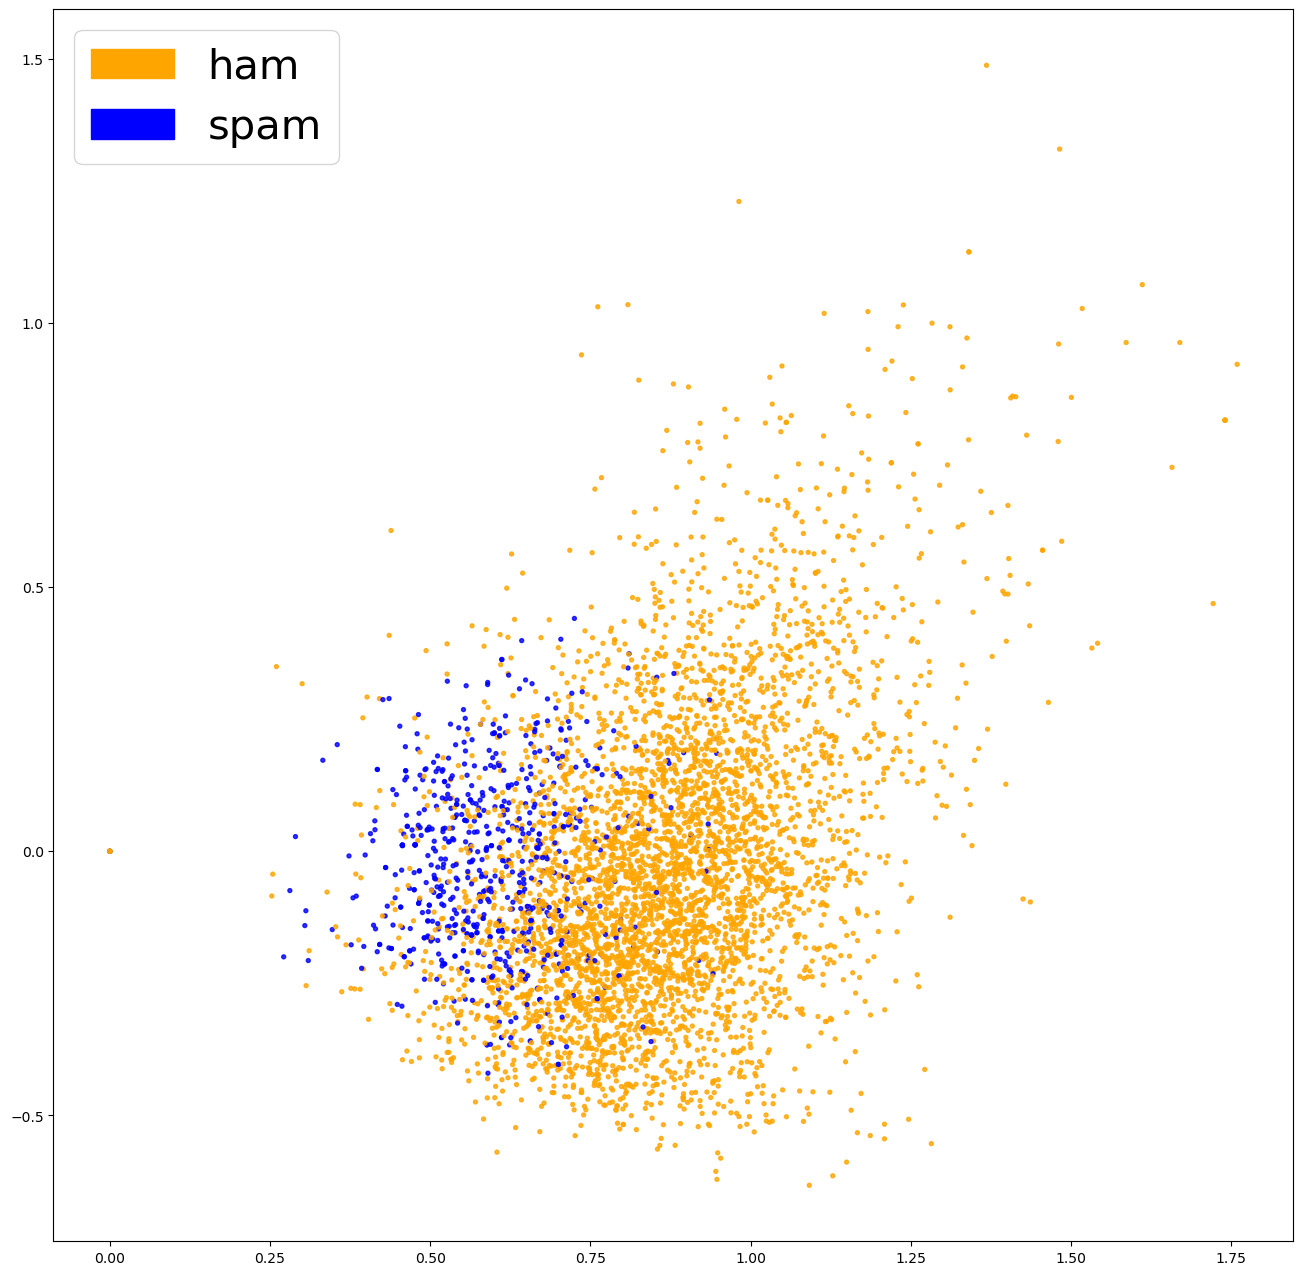

In [206]:
fig = plt.figure(figsize=(16, 16))
plot_LSA(embeddings, list_labels)
plt.show()

Разделение очень чётко видно

In [232]:
clf_w2v = LogisticRegression(C=30.0, class_weight='balanced', solver='newton-cg',
                         multi_class='multinomial', random_state=40)
clf_w2v.fit(X_train_word2vec, y_train_word2vec)
y_predicted_word2vec = clf_w2v.predict(X_test_word2vec)

In [234]:
accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec, r2_word2vec = get_metrics(y_test_word2vec, y_predicted_word2vec)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy_word2vec, precision_word2vec, recall_word2vec, f1_word2vec, r2_word2vec))

accuracy = 0.949, precision = 0.959, recall = 0.949, f1 = 0.952, r2 = 0.493


Несмотря на то, что метрики ухудшились, у нас получилась хорошая обученная модель, которая может верно классифицировать сообщения

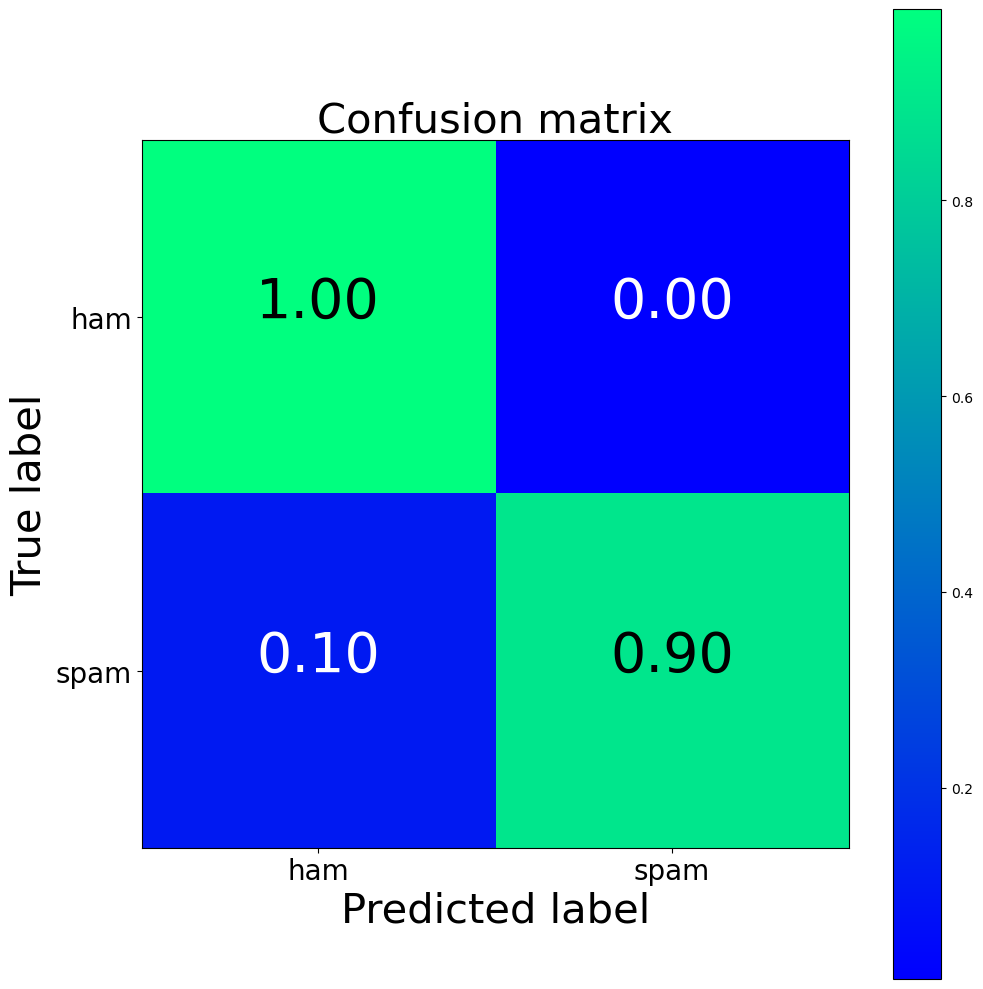

Word2Vec confusion matrix
[[871  45]
 [  8 110]]
TFIDF confusion matrix
[[907   9]
 [  5 113]]
BoW confusion matrix
[[912   4]
 [ 12 106]]


In [238]:
cm_w2v = confusion_matrix(y_test_word2vec, y_predicted_word2vec)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['ham','spam'], normalize=True, title='Confusion matrix')
plt.show()
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

### Further inspection


Поскольку наши векторные представления более не представлены в виде вектора с одним измерением на слово, как было в предыдущих моделях, теперь тяжелее понять, какие слова наиболее релевантны для нашей классификации. Несмотря на то, что мы по-прежнему обладаем доступом к коэффициентам нашей логистической регрессии, они относятся к 300 измерениям наших вложений, а не к индексам слов.

Для столь небольшого прироста точности, полная потеря возможности объяснить работу модели — это слишком жесткий компромисс. К счастью, при работе с более сложными моделями мы можем использовать интерпретаторы наподобие LIME, которые применяются для того, чтобы получить некоторое представление о том, как работает классификатор.

#### LIME

LIME доступен на Github в виде открытого пакета. Данный интерпретатор, работающий по принципу черного ящика, позволяет пользователям объяснять решения любого классификатора на одном конкретном примере при помощи изменения ввода (в нашем случае — удаления слова из предложения) и наблюдения за тем, как изменяется предсказание.

Давайте взглянем на пару объяснений для предложений из нашего датасета.

In [240]:
_train_data, X_test_data, y_train_data, y_test_data = train_test_split(list_corpus, list_labels, test_size=0.2,
                                                                                random_state=40)
vector_store = word2vec
def word2vec_pipeline(examples):
    global vector_store
    tokenizer = RegexpTokenizer(r'\w+')
    tokenized_list = []
    for example in examples:
        example_tokens = tokenizer.tokenize(example)
        vectorized_example = get_average_word2vec(example_tokens, vector_store, generate_missing=False, k=300)
        tokenized_list.append(vectorized_example)
    return clf_w2v.predict_proba(tokenized_list)

c = make_pipeline(count_vectorizer, clf)

In [250]:
def explain_one_instance(instance, class_names):
    explainer = LimeTextExplainer(class_names=class_names)
    exp = explainer.explain_instance(instance, word2vec_pipeline, num_features=6)
    return exp

def visualize_one_exp(features, labels, index, class_names = ["ham","spam"]):
    exp = explain_one_instance(features[index], class_names = class_names)
    print('Index: %d' % index)
    print('True class: %s' % class_names[labels[index]])
    exp.show_in_notebook(text=True)

In [274]:
visualize_one_exp(X_test_data, y_test_data, 22)

Index: 22
True class: spam


In [276]:
visualize_one_exp(X_test_data, y_test_data, 60)

Index: 60
True class: ham


Давайте запустим LIME на репрезентативной выборке тестовых данных, и посмотрим, какие слова встречаются регулярно и вносят наибольший вклад в конечный результат. Используя данный подход, мы можем получить оценки значимости слов аналогично тому, как мы делали это для предыдущих моделей, и валидировать предсказания нашей модели.

In [278]:
random.seed(40)

def get_statistical_explanation(test_set, sample_size, word2vec_pipeline, label_dict):
    sample_sentences = random.sample(test_set, sample_size)
    explainer = LimeTextExplainer()

    labels_to_sentences = defaultdict(list)
    contributors = defaultdict(dict)

    # First, find contributing words to each class
    for sentence in sample_sentences:
        probabilities = word2vec_pipeline([sentence])
        curr_label = probabilities[0].argmax()
        labels_to_sentences[curr_label].append(sentence)
        exp = explainer.explain_instance(sentence, word2vec_pipeline, num_features=6, labels=[curr_label])
        listed_explanation = exp.as_list(label=curr_label)

        for word,contributing_weight in listed_explanation:
            if word in contributors[curr_label]:
                contributors[curr_label][word].append(contributing_weight)
            else:
                contributors[curr_label][word] = [contributing_weight]

    # average each word's contribution to a class, and sort them by impact
    average_contributions = {}
    sorted_contributions = {}
    for label,lexica in contributors.items():
        curr_label = label
        curr_lexica = lexica
        average_contributions[curr_label] = pd.Series(index=curr_lexica.keys())
        for word,scores in curr_lexica.items():
            average_contributions[curr_label].loc[word] = np.sum(np.array(scores))/sample_size
        detractors = average_contributions[curr_label].sort_values()
        supporters = average_contributions[curr_label].sort_values(ascending=False)
        sorted_contributions[label_dict[curr_label]] = {
            'detractors':detractors,
             'supporters': supporters
        }
    return sorted_contributions

label_to_text = {
    0: 'ham',
    1: 'spam',
}
sorted_contributions = get_statistical_explanation(X_test_data, 100, word2vec_pipeline, label_to_text)

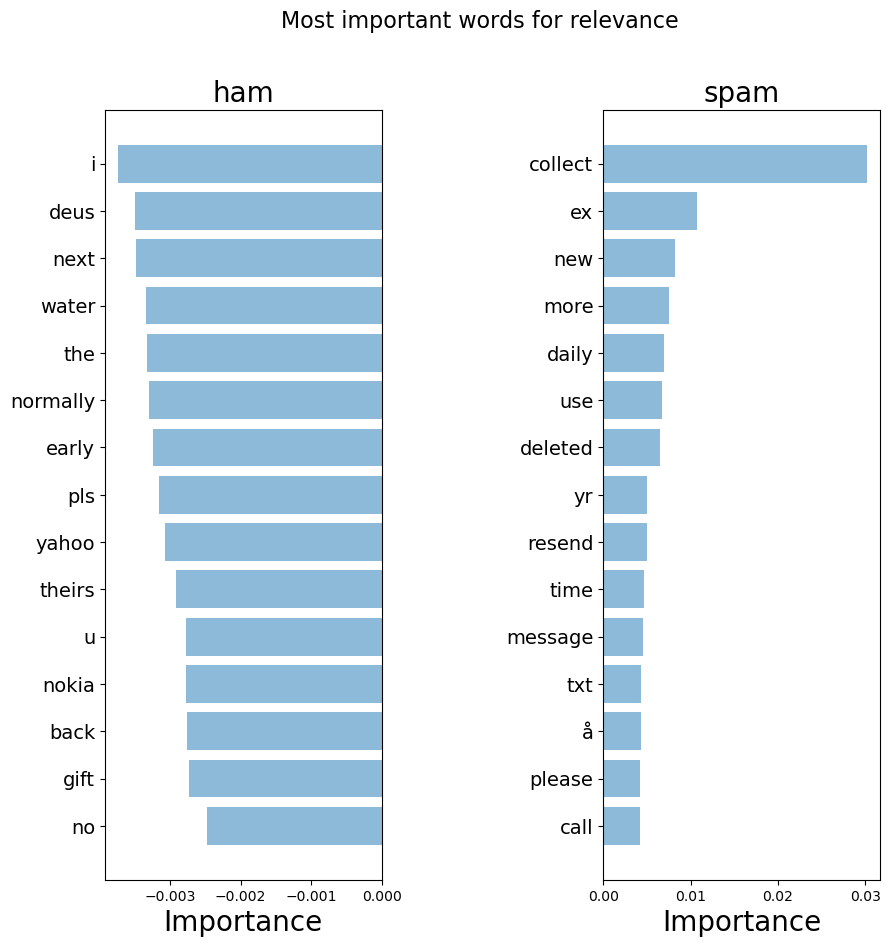

In [290]:
# First index is the class (Disaster)
# Second index is 0 for detractors, 1 for supporters
# Third is how many words we sample
top_words = sorted_contributions['spam']['supporters'][:15].index.tolist()
top_scores = sorted_contributions['ham']['supporters'][:15].tolist()
bottom_words = sorted_contributions['spam']['detractors'][:15].index.tolist()
bottom_scores = sorted_contributions['ham']['detractors'][:15].tolist()

plot_important_words(top_scores, top_words, bottom_scores, bottom_words,"Most important words for relevance")

### Использование синтаксиса при применении end-to-end подходов ###

Мы рассмотрели быстрые и эффективные подходы для генерации компактных векторных представлений предложений. Однако, опуская порядок слов, мы отбрасываем всю синтаксическую информацию из наших предложений. Если эти методы не дают достаточных результатов, вы можете использовать более сложную модель, которая принимает целые выражения в качестве ввода и предсказывает метки, без необходимости построения промежуточного представления. Распространенный для этого способ состоит в рассмотрении предложения как последовательности индивидуальных векторов слов с использованием или Word2Vec, или более свежих подходов вроде GloVe или CoVe. Именно этим мы и займемся далее.

CNN для NLP

Сверточные нейронные сети для классификации предложений (CNNs for Sentence Classification) обучаются очень быстро и могут сослужить отличную службу в качестве входного уровня в архитектуре глубокого обучения. Несмотря на то, что сверточные нейронные сети (CNN) в основном известны своей высокой производительностью на данных-изображениях, они показывают превосходные результаты при работе с текстовыми данными, и обычно гораздо быстрее обучаются, чем большинство сложных подходов NLP (например, LSTM-сети и архитектуры Encoder/Decoder ). Эта модель сохраняет порядок слов и обучается ценной информации о том, какие последовательности слов служат предсказанием наших целевых классов. В отличии от предыдущих моделей, она в курсе существования разницы между фразами «Лёша ест растения» и «Растения едят Лёшу».

In [298]:
EMBEDDING_DIM = 300
MAX_SEQUENCE_LENGTH = 35
VOCAB_SIZE = len(VOCAB)

VALIDATION_SPLIT=.2
tokenizer = Tokenizer(num_words=VOCAB_SIZE)
tokenizer.fit_on_texts(clean_questions["text"].tolist())
sequences = tokenizer.texts_to_sequences(clean_questions["text"].tolist())

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

cnn_data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)
labels = to_categorical(np.asarray(clean_questions["target"]))

indices = np.arange(cnn_data.shape[0])
np.random.shuffle(indices)
cnn_data = cnn_data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * cnn_data.shape[0])

embedding_weights = np.zeros((len(word_index)+1, EMBEDDING_DIM))
for word,index in word_index.items():
    embedding_weights[index,:] = word2vec[word] if word in word2vec else np.random.rand(EMBEDDING_DIM)
print(embedding_weights.shape)

Found 8920 unique tokens.
(8921, 300)


In [300]:
def ConvNet(embeddings, max_sequence_length, num_words, embedding_dim, labels_index, trainable=False, extra_conv=True):

    embedding_layer = Embedding(num_words,
                            embedding_dim,
                            weights=[embeddings],
                            input_length=max_sequence_length,
                            trainable=trainable)

    sequence_input = Input(shape=(max_sequence_length,), dtype='int32')
    embedded_sequences = embedding_layer(sequence_input)

    # Yoon Kim model (https://arxiv.org/abs/1408.5882)
    convs = []
    filter_sizes = [3,4,5]

    for filter_size in filter_sizes:
        l_conv = Conv1D(filters=128, kernel_size=filter_size, activation='relu')(embedded_sequences)
        l_pool = MaxPooling1D(pool_size=3)(l_conv)
        convs.append(l_pool)

    l_merge = Concatenate(axis=1)(convs)

    # add a 1D convnet with global maxpooling, instead of Yoon Kim model
    conv = Conv1D(filters=128, kernel_size=3, activation='relu')(embedded_sequences)
    pool = MaxPooling1D(pool_size=3)(conv)

    if extra_conv==True:
        x = Dropout(0.5)(l_merge)
    else:
        # Original Yoon Kim model
        x = Dropout(0.5)(pool)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    #x = Dropout(0.5)(x)

    preds = Dense(labels_index, activation='softmax')(x)

    model = Model(sequence_input, preds)
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['acc'])

    return model

Теперь давайте потренируем нашу нейронную сеть

In [304]:
x_train = cnn_data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = cnn_data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

model = ConvNet(embedding_weights, MAX_SEQUENCE_LENGTH, len(word_index)+1, EMBEDDING_DIM,
                len(list(clean_questions["target"].unique())), False)

C:\Users\lizas\anaconda3\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [306]:
model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=3, batch_size=128)

Epoch 1/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - acc: 0.8695 - loss: 0.3006 - val_acc: 0.9351 - val_loss: 0.1737
Epoch 2/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - acc: 0.9547 - loss: 0.1155 - val_acc: 0.9748 - val_loss: 0.0790
Epoch 3/3
33/33 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - acc: 0.9842 - loss: 0.0465 - val_acc: 0.9768 - val_loss: 0.0908


In [308]:
y_pred = model.predict(x_val)

33/33 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [310]:
y_pred_cnn = np.argmax(y_pred, axis=1)
y_val_cnn = np.argmax(y_val, axis=1)

In [312]:
accuracy_cnn, precision_cnn, recall_cnn, f1_cnn, r2_cnn = get_metrics(y_val_cnn, y_pred_cnn)
print("accuracy = %.3f, precision = %.3f, recall = %.3f, f1 = %.3f, r2 = %.3f" % (accuracy_cnn, precision_cnn, recall_cnn, f1_cnn, r2_cnn))

accuracy = 0.977, precision = 0.977, recall = 0.977, f1 = 0.977, r2 = 0.780


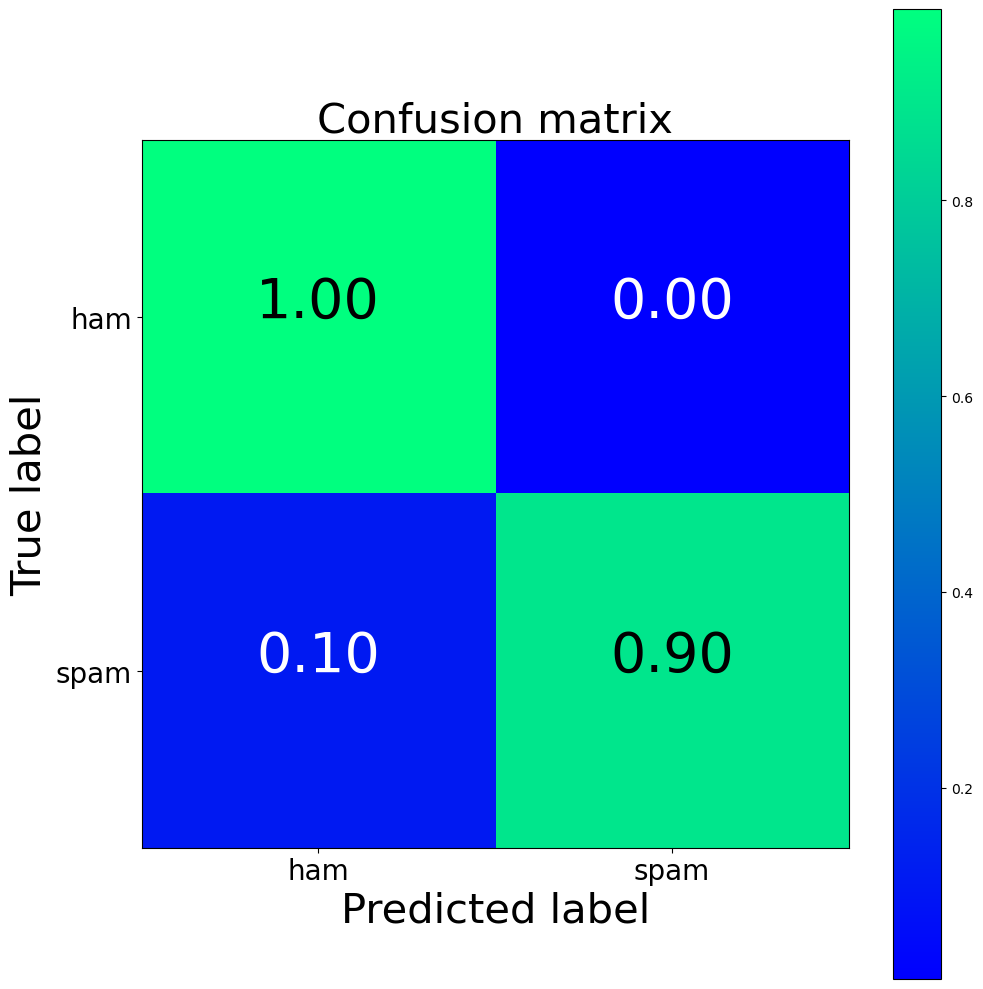

CNN confusion matrix
[[895  14]
 [ 10 114]]
Word2Vec confusion matrix
[[871  45]
 [  8 110]]
TFIDF confusion matrix
[[907   9]
 [  5 113]]
BoW confusion matrix
[[912   4]
 [ 12 106]]


In [316]:
cm_cnn = confusion_matrix(y_val_cnn, y_pred_cnn)
fig = plt.figure(figsize=(10, 10))
plot = plot_confusion_matrix(cm, classes=['ham','spam'], normalize=True, title='Confusion matrix')
plt.show()

print("CNN confusion matrix")
print(cm_cnn)
print("Word2Vec confusion matrix")
print(cm_w2v)
print("TFIDF confusion matrix")
print(cm2)
print("BoW confusion matrix")
print(cm)

Самой лучшей моделью оказалась Логистическая регрессия, но для работы с другими сообщениями лучше использовать CNN 